# Introducing Active Views

Black-Litterman Approach

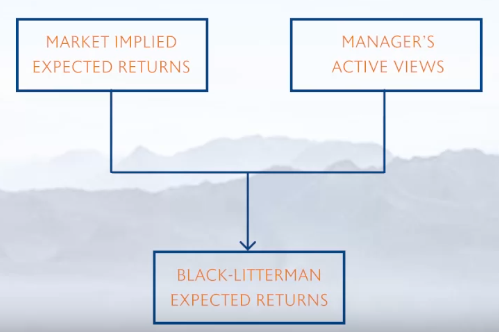

Active Views is expressed as a normal distribution with mean equal to Q and a standard deviation given by Omega.

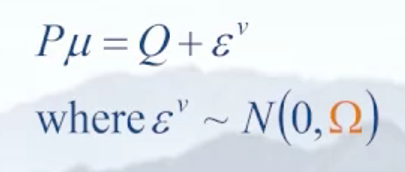

Q:

Assume that a manager’s active views for stock 1 return is 15% and it is 10% for stock 2 return. Does this imply that:

A:

Regarding the first statement: it can happen that the benchmark implied expected return for stock 1 are is higher than 15%, in which case stock 1 should be underweighted compared to the benchmark, and it can also happen that the benchmark implied expected return for stock 2 is lower than 10% in which case stock 2 should be overweighted compared to the benchmark. Regarding the second statement: in the absence of information about volatilities of these stocks and their correlations with the rest of the portfolio constituents, a higher return is not a sufficient condition for a higher allocation.  


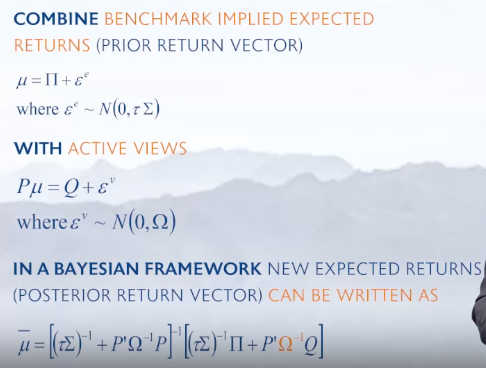

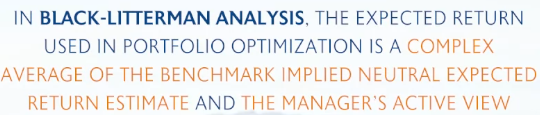

# Black-Litterman Analysis

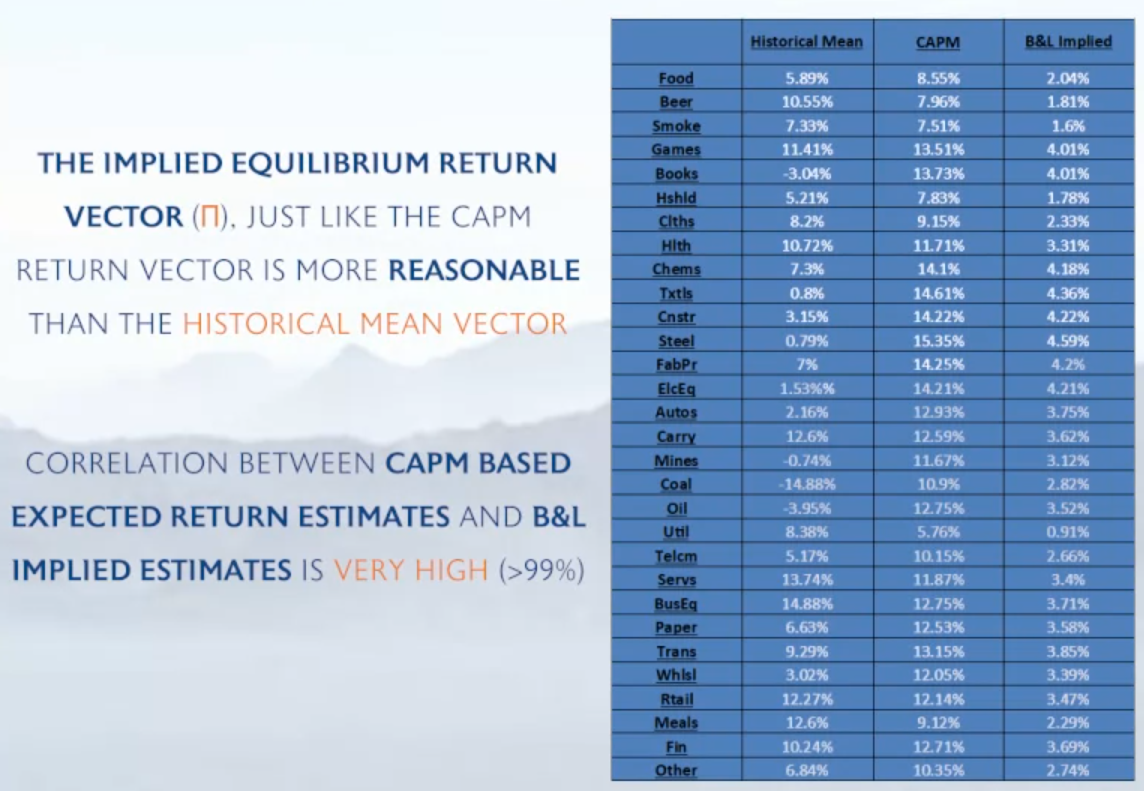

B&L analysis can be performed using an equally-weighted (EW) portfolio as a benchmark. 

The B&L approach can be extended to any benchmark. For this just derive in the first step implied expected returns consistent with the EW portfolio being the Max Sharpe Ratio portfolio.

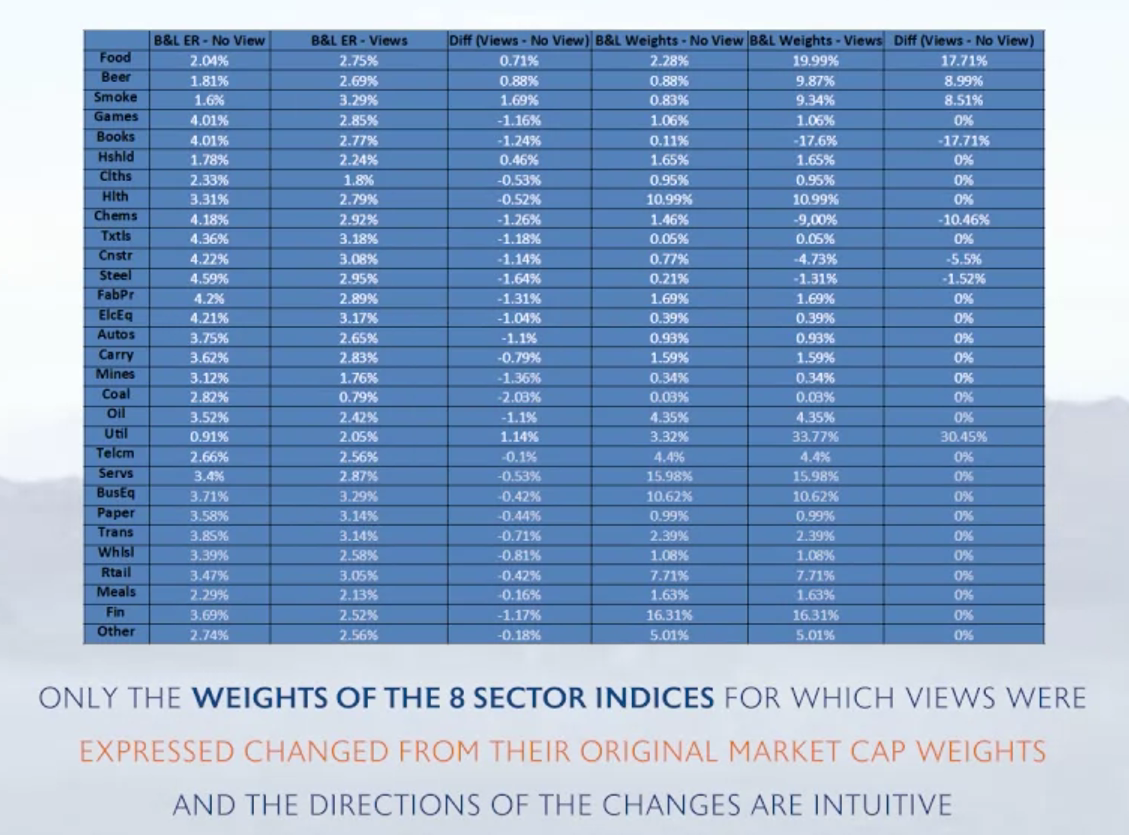

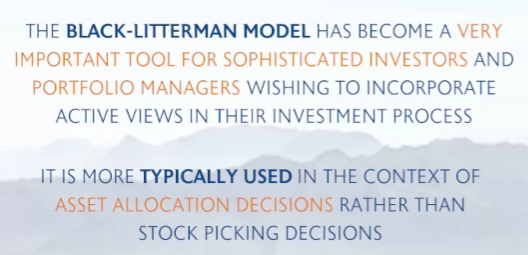

# Lab Session- Black Litterman

In [106]:
import numpy as np
import pandas as pd
import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
inds = ['Hlth','Fin','Whlsl','Rtail', 'Food']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2013":"2018"]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["2013":"2018"]


mcap = ind_mcap[inds]
rets = ind_rets[inds]
rho = rets.corr()
vols = rets.std()*np.sqrt(12)
sigma_prior = vols.dot(vols.T) * rho
ind_w = mcap.values[0]/mcap.values[0].sum()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


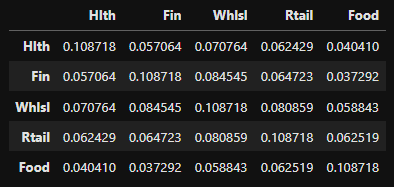

In [107]:
ind_w

array([0.0416629 , 0.17536186, 0.09741073, 0.54638822, 0.13917629])

In [108]:
# Which industry sector has the highest capweight?
w_eq = pd.DataFrame(ind_w, index=inds, columns=["CapWeight"])
w_eq.sort_values('CapWeight')

,CapWeight
Hlth,0.041663
Whlsl,0.097411
Food,0.139176
Fin,0.175362
Rtail,0.546388


In [109]:
# which industry sector has the highest implied return? 

def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir

In [110]:
pi = implied_returns(delta=2.5, sigma=sigma_prior, w=ind_w)
pi*100

Hlth     15.290998
Fin      17.558006
Whlsl    20.183618
Rtail    22.482690
Food     15.811480
Name: Implied Returns, dtype: float64

In [111]:
#Sort data
sorted_data = sorted(pi.items(), key=lambda x: x[1])
for category, value in sorted_data:
    print(f'{category}: {round(value,4)}')

Hlth: 0.1529
Food: 0.1581
Fin: 0.1756
Whlsl: 0.2018
Rtail: 0.2248


In [112]:
# Impose the subjective relative view that Hlth will outperform Rtail and Whlsl by 3%
# What is the entry you will use for the Pick Matrix P for Whlsl.
# What is the entry you will use for the Pick Matrix P for Rtail.
# Hlth will outperform Rtail and Whlsl by 3%
q = pd.Series([.03]) # just one view
# start with a single view, all zeros and overwrite the specific view
p = pd.DataFrame([0.]*len(inds), index=inds).T
# find the relative market caps of Rtail and Whlsl to split the
# relative outperformance of Hlth ...
w_rtail =  w_eq.loc["Rtail"]/(w_eq.loc["Rtail"]+w_eq.loc["Whlsl"])
w_whlsl =  w_eq.loc["Whlsl"]/(w_eq.loc["Rtail"]+w_eq.loc["Whlsl"])
p.iloc[0]['Hlth'] = 1.
p.iloc[0]['Rtail'] = -w_rtail
p.iloc[0]['Whlsl'] = -w_whlsl
(p).round(3)

C:\Users\lishe\AppData\Local\Temp\ipykernel_8840\2831358284.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p.iloc[0]['Rtail'] = -w_rtail
C:\Users\lishe\AppData\Local\Temp\ipykernel_8840\2831358284.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p.iloc[0]['Whlsl'] = -w_whlsl


,Hlth,Fin,Whlsl,Rtail,Food
0,1.0,0.0,-0.151,-0.849,0.0


In [113]:
# Impose the subjective relative view that Hlth will outperform Rtail and Whlsl by 3% 
# (Hint: Use the same logic as View 1 in the He-Litterman paper) 
# Once you impose this view (use delta = 2.5 and tau = 0.05 as in the paper), which sector has the lowest implied return?

# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)


In [114]:
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)

In [115]:
delta = 2.5
tau = 0.05 # from Footnote 8
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
(bl_mu*100).round(1).sort_values()

Food     14.5
Fin      16.9
Hlth     18.0
Whlsl    19.3
Rtail    20.0
dtype: float64

In [116]:
# Which sector now has the highest and lowest weight in the MSR portfolio using the Black-Litterman model?

# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w

In [117]:
# Use the Black Litterman expected returns to get the Optimal Markowitz weights
w_msr(bl_sigma, bl_mu).sort_values()

Whlsl    0.061820
Food     0.139176
Fin      0.175362
Hlth     0.276885
Rtail    0.346756
dtype: float64